In [1]:
import numpy
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
import numpy as np
import pandas

sys.path.append('..')
from synthpop_main import SynthPop
from synthpop_utils import half_cone_angle_to_solidangle
from synthpop_utils.coordinates_transformation import CoordTrans

In [2]:
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
from astroquery.gaia import Gaia, GaiaClass
from astroquery.vizier import Vizier

GaiaModel = GaiaClass()
GaiaModel.MAIN_GAIA_TABLE = "gaiadr3.gaia_universe_model"
GaiaModel.ROW_LIMIT = 10000000
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 10000000
GUMS_QUERY = Vizier(row_limit=-1, catalog="VI/137/gum_mw")

In [108]:
mod1 = SynthPop(sun={"x": 8, "y": 0, "z":0.015}, name_for_output="gums", model_name="GUMS_dr3", max_distance=25,
                    extinction_map_kwargs={"name":"gums"}, evolution_class={"name":"MIST", "interpolator":"CharonInterpolator"},
                    chosen_bands=["Gaia_G_EDR3", "Gaia_BP_EDR3", "Gaia_RP_EDR3"],
                    maglim=["Gaia_G_EDR3", 21, "keep"], lost_mass_option=2,
                    post_processing_kwargs={"name": "ProcessDarkCompactObjects"},
                    output_location="/u/mhuston/code/synthpop/outputfiles/gums_comp",
                    output_file_type="hdf5", overwrite=True, chunk_size=250000
               )
mod2 = SynthPop(sun={"x": 8, "y": 0, "z":0.015}, name_for_output="gums_mod", model_name="GUMS_dr3_mod_dens", max_distance=25,
                    extinction_map_kwargs={"name":"gums"}, evolution_class={"name":"MIST", "interpolator":"CharonInterpolator"},
                    chosen_bands=["Gaia_G_EDR3", "Gaia_BP_EDR3", "Gaia_RP_EDR3"],
                    maglim=["Gaia_G_EDR3", 21, "keep"], lost_mass_option=2,
                    post_processing_kwargs={"name": "ProcessDarkCompactObjects"},
                    output_location="/u/mhuston/code/synthpop/outputfiles/gums_comp",
                    output_file_type="hdf5", overwrite=True, chunk_size=250000)



################################ Settings #################################
# reading default parameters from
default_config_file =  /System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/config_files/_default.synthpop_conf 


# copy the following to a config file to redo this model generation -------
{
    "l_set": null,
    "l_set_type": null,
    "b_set": null,
    "b_set_type": null,
    "name_for_output": "gums",
    "model_name": "GUMS_dr3",
    "solid_angle": null,
    "solid_angle_unit": "deg^2",
    "random_seed": 1728901420,
    "sun": {
        "x": 8,
        "y": 0,
        "z": 0.015
    },
    "lsr": {
        "u_lsr": 1.8,
        "v_lsr": 233.4,
        "w_lsr": 0.53
    },
    "warp": {
        "r_warp": 7.72,
        "amp_warp": 0.06,
        "amp_warp_pos": null,
        "amp_warp_neg": null,
        "alpha_warp": 1.33,
        "phi_warp_deg": 17.5
    },
    "max_distance": 25,
    "distance_step_size": 0.1,
    "window_type": {
        "window_type":

In [109]:
mod1.init_populations()
mod2.init_populations()



########################## initialize population ##########################
read Population files from GUMS_dr3


# Population 0;  bar ------------------------------------------------------
# Initialize Population 0 (bar) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GUMS_dr3/bar.popjson'


# Population 1;  disk1 ----------------------------------------------------
# Initialize Population 1 (disk1) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GUMS_dr3/disk1.popjson'


# Population 2;  disk2 ----------------------------------------------------
# Initialize Population 2 (disk2) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GUMS_dr3/disk2.popjson'


# Population 3;  disk3 ----------------------------------------------------
# Initialize Population 3 (disk3) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GU

In [112]:
locs=[[2,-2],[30,30]]
radiuss=[0.03*u.degree, 0.5*u.degree, 0.5*u.degree]
solangs = [radius**2*np.pi for radius in radiuss]
do_is = [0,1]

In [ ]:
for i,loc in enumerate(locs):
    if i in do_is:
        mod1.process_location(l_deg=loc[0],b_deg=loc[1], solid_angle=solangs[i].value, solid_angle_unit="deg^2")
        mod2.process_location(l_deg=loc[0],b_deg=loc[1], solid_angle=solangs[i].value, solid_angle_unit="deg^2")



############################# update location #############################
# set location to: 
l, b = (2.00 deg, -2.00 deg)
# set solid_angle to:
solid_angle = 2.827e-03 deg^2


############################# Generate Field ##############################


# Population 0;  bar ------------------------------------------------------
# From density profile (number density)
expected_total_iMass = 90140467.0250
expected_total_eMass = 1416290.9049
average_iMass_per_star = 34.3028
mass_loss_correction = 0.0157
n_expected_stars = 2627786.7482
# Determine velocities when position are generated 


In [94]:
cat1b=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_l2.000_b-2.000.h5")
cat2b=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_mod_dens_l2.000_b-2.000.h5")

#cat1d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_l20.000_b15.000.csv")
#cat2d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_mod_dens_l20.000_b15.000.csv")

cat1d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_l30.000_b30.000.h5")
cat2d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_mod_dens_l30.000_b30.000.h5")

In [96]:
comps = ['bulge','disk']
for i,loc in enumerate(locs):
    if i in do_is:
        coord = SkyCoord(l=loc[0] * u.degree, b=loc[1] * u.degree, frame=Galactic)
        print('Querying Gaia')
        job = Gaia.cone_search_async(coord, radiuss[i])
        gaia_tab = job.get_results().to_pandas()[['phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp']]
        print('Querying GUMS')
        job = GaiaModel.cone_search_async(coord, radiuss[i])
        gums_tab = job.get_results().to_pandas()[['mag_g','mag_bp','mag_rp','mass','barycentric_distance','population','age',
                                                  "classprob_dsc_combmod_star"]]["classprob_dsc_combmod_star"] >= 0.5]
        print('Saving to files')
        gaia_tab.to_hdf('gums_compare/gaia_'+comps[i]+'.h5',key='data',index=False)
        gums_tab.to_hdf('gums_compare/gums_'+comps[i]+'.h5',key='data',index=False)

Querying Gaia
INFO: Query finished. [astroquery.utils.tap.core]
Querying GUMS
INFO: Query finished. [astroquery.utils.tap.core]
Saving to files


In [97]:
gaia_tab_b = pandas.read_hdf('gums_compare/gaia_bulge.h5',key='data')
gums_tab_b = pandas.read_hdf('gums_compare/gums_bulge.h5',key='data')

gaia_tab_d = pandas.read_hdf('gums_compare/gaia_disk2.h5',key='data')
gums_tab_d = pandas.read_hdf('gums_compare/gums_disk2.h5',key='data')

In [98]:
labs=['GUMS','sp','sp-mod','all sp-mod', 'gaia']

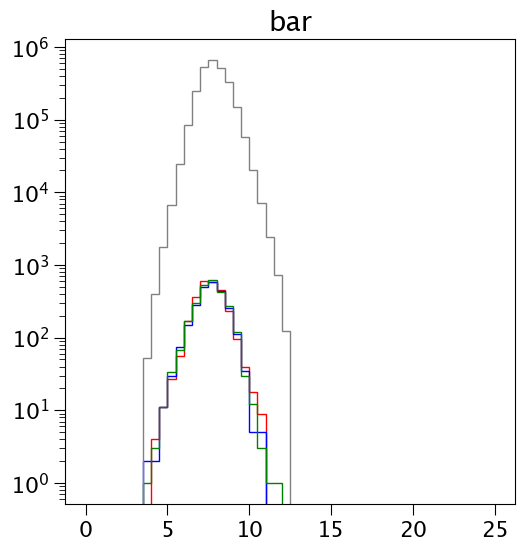

In [99]:
bins=np.arange(0,25.01,0.5)
plt.title('bar')
plt.hist(gums_tab_b[(gums_tab_b.mag_g<20) & (gums_tab_b.population==4)].barycentric_distance/1000,bins=bins,histtype='step',color='r')
plt.hist(cat1b[(cat1b.Gaia_G_EDR3<20) & (cat1b['pop']>-0.5) & (cat1b['pop']<0.5)].Dist,bins=bins,histtype='step',color='b')
plt.hist(cat2b[(cat2b.Gaia_G_EDR3<20) & (cat2b['pop']>-0.5) & (cat2b['pop']<0.5)].Dist,bins=bins,histtype='step',color='g')
plt.hist(cat2b[(cat2b['pop']>-0.5) & (cat2b['pop']<0.5)].Dist,bins=bins,histtype='step',color='grey')
plt.yscale('log')

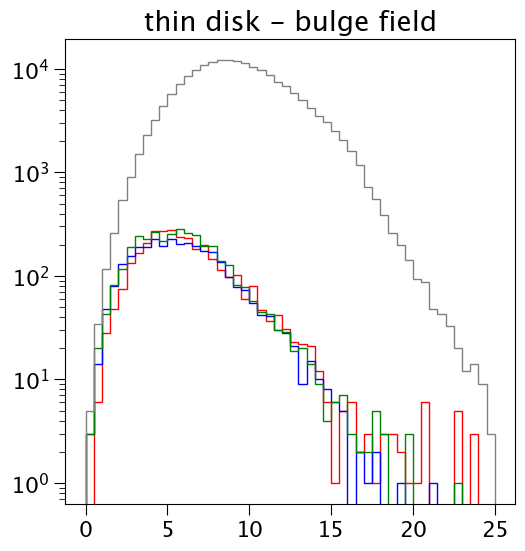

In [100]:
bins=np.arange(0,25.01,0.5)
plt.title('thin disk - bulge field')
plt.hist(gums_tab_b[(gums_tab_b.mag_g<20) & (gums_tab_b.population==1)].barycentric_distance/1000,bins=bins,histtype='step',color='r')
plt.hist(cat1b[(cat1b.Gaia_G_EDR3<20) & (cat1b['pop']>0.5) & (cat1b['pop']<7.5)].Dist,bins=bins,histtype='step',color='b')
plt.hist(cat2b[(cat2b.Gaia_G_EDR3<20) & (cat2b['pop']>0.5) & (cat2b['pop']<7.5)].Dist,bins=bins,histtype='step',color='g')
plt.hist(cat2b[(cat2b['pop']>0.5) & (cat2b['pop']<7.5)].Dist,bins=bins,histtype='step',color='grey')
plt.yscale('log')

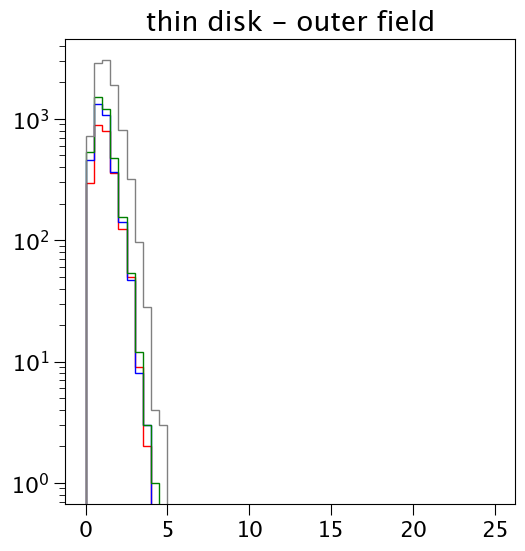

In [101]:
bins=np.arange(0,25.01,0.5)
plt.title('thin disk - outer field')
plt.hist(gums_tab_d[(gums_tab_d.mag_g<20) & (gums_tab_d.population==1)].barycentric_distance/1000,bins=bins,histtype='step',color='r')
plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>0.5) & (cat1d['pop']<7.5)].Dist,bins=bins,histtype='step',color='b')
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20) & (cat2d['pop']>0.5) & (cat2d['pop']<7.5)].Dist,bins=bins,histtype='step',color='g')
plt.hist(cat2d[(cat2d['pop']>0.5) & (cat2d['pop']<7.5)].Dist,bins=bins,histtype='step',color='grey')
plt.yscale('log')

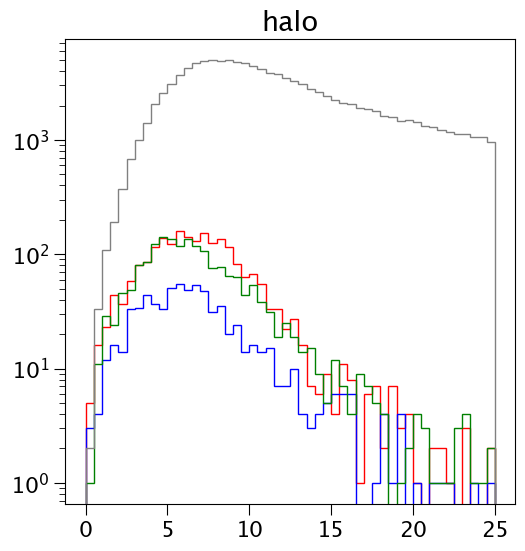

In [102]:
bins=np.arange(0,25.01,0.5)
plt.title('halo')
plt.hist(gums_tab_d[(gums_tab.mag_g<20) & (gums_tab_d.population==3)].barycentric_distance/1000,bins=bins,histtype='step',color='r')
plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>7.5) & (cat1d['pop']<8.5)].Dist,bins=bins,histtype='step',color='b')
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20) & (cat2d['pop']>7.5) & (cat2d['pop']<8.5)].Dist,bins=bins,histtype='step',color='g')
plt.hist(cat2d[(cat2d['pop']>7.5) & (cat2d['pop']<8.5)].Dist,bins=bins,histtype='step',color='grey')
plt.yscale('log')

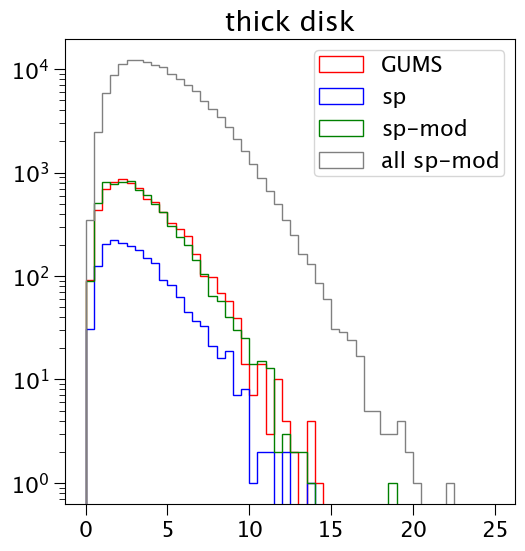

In [103]:
bins=np.arange(0,25.01,0.5)
plt.title('thick disk')
plt.hist(gums_tab_d[(gums_tab_d.mag_g<20) & (gums_tab_d.population==2)].barycentric_distance/1000,bins=bins,histtype='step',color='r',label=labs[0])
plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>8.5) & (cat1d['pop']<10.5)].Dist,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20) & (cat2d['pop']>8.5) & (cat2d['pop']<10.5)].Dist,bins=bins,histtype='step',color='g',label=labs[2])
plt.hist(cat2d[(cat2d['pop']>8.5) & (cat2d['pop']<10.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.legend()
plt.yscale('log')

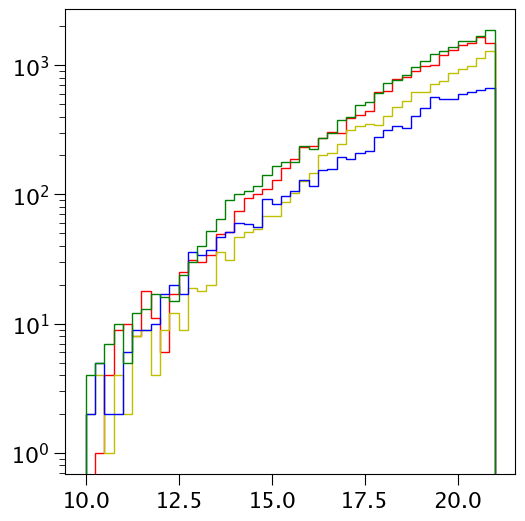

In [106]:
bins = np.arange(10,21.01,0.25)
plt.hist(gums_tab_d.mag_g,bins=bins, histtype='step',label=labs[0], color='r')
plt.hist(gaia_tab_d.phot_g_mean_mag,bins=bins, histtype='step',label=labs[4], color='y')
plt.hist(cat1d.Gaia_G_EDR3,bins=bins, histtype='step',label=labs[1], color='b')
plt.hist(cat2d.Gaia_G_EDR3,bins=bins, histtype='step',label=labs[2], color='g')
plt.yscale('log')

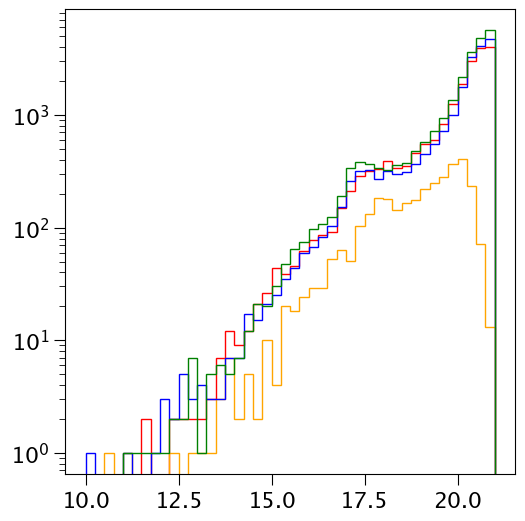

In [105]:
bins = np.arange(10,21.01,0.25)
plt.hist(gums_tab_b.mag_g,bins=bins, histtype='step',label=labs[0], color='r')
plt.hist(gaia_tab_b.phot_g_mean_mag,bins=bins, histtype='step',label=labs[4], color='orange')
plt.hist(cat1b.Gaia_G_EDR3,bins=bins, histtype='step',label=labs[1], color='b')
plt.hist(cat2b.Gaia_G_EDR3,bins=bins, histtype='step',label=labs[2], color='g')
plt.yscale('log')